# Plants Classification

## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout ,GlobalAveragePooling2D, Activation, Rescaling
from keras.models import Sequential, Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.applications import InceptionResNetV2, MobileNetV2
from tensorflow.keras import regularizers
import os, shutil
import warnings
warnings.filterwarnings('ignore')

## Download Dataset

In [2]:
!pip install -q opendatasets

import opendatasets as od

# insert your username and kaggle api key from kaggle.json file
od.download('https://www.kaggle.com/datasets/marquis03/plants-classification')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: afrizameidioandhana
Your Kaggle Key: ··········


100%|██████████| 1.34G/1.34G [00:13<00:00, 103MB/s]


In [3]:
pip install split-folders

In [17]:
output_path = '/content/dataset'
data_path = '/content/plants-classification/train'

# Folder yang dipilih
selected_folders = ['aloevera', 'banana', 'pineapple','cassava', 'coconut', 'cucumber','papaya', 'corn', 'eggplant', 'watermelon', 'shallot', 'guava', 'mango','melon', 'orange']

for folder in selected_folders:
    # Path lengkap menuju folder saat ini di dataset asli
    source_folder = os.path.join(data_path, folder)

    # Path lengkap menuju folder di folder output
    destination_folder = os.path.join(output_path, folder)

    # Mengkopi folder dari dataset asli ke folder output
    shutil.copytree(source_folder, destination_folder)

print("Proses selesai.")

Proses selesai.


In [26]:
import splitfolders
splitfolders.ratio('/content/dataset', output="plant_pict", seed=1337, ratio=(0.8, 0.2))

Copying files: 10500 files [00:10, 1038.16 files/s]


In [27]:
train_data = "/content/plant_pict/train"
validation_data = "/content/plant_pict/val"

## Augmentasi Gambar

In [28]:
train_gen = ImageDataGenerator( featurewise_center=False,
                                samplewise_center=False,
                                featurewise_std_normalization=False,
                                samplewise_std_normalization=False,
                                zca_whitening=False,
                                rotation_range=10,
                                zoom_range = 0.1,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=False,
                              )

train_image_generator = train_gen.flow_from_directory(
                                            train_data,
                                            target_size=(150, 150),
                                            batch_size=64,
                                            class_mode='categorical')


val_gen = ImageDataGenerator(   horizontal_flip=True,
                                vertical_flip=False,)

val_image_generator = val_gen.flow_from_directory(
                                            validation_data,
                                            target_size=(150, 150),
                                            batch_size=64,
                                            class_mode='categorical')

Found 8400 images belonging to 15 classes.
Found 2100 images belonging to 15 classes.


In [29]:
base_model = InceptionResNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)

# Freeze the base_model
base_model.trainable = True

## CNN Model

In [30]:
model = tf.keras.models.Sequential([
    Rescaling(scale=1 / 127.5, offset=-1),
    base_model,
    Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(None, None, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(64, kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(15, activation='softmax')
])

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics='accuracy')

## Callback

In [32]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      print("accuracy > 92% skala data")
      self.model.stop_training = True
callbacks = myCallback()

early_stopping = keras.callbacks.EarlyStopping(patience=3,monitor='val_loss',restore_best_weights=True)

## Model Train

In [33]:
history = model.fit(train_image_generator,
                 steps_per_epoch=30,
                 epochs=50,
                 verbose=1,
                 validation_data=val_image_generator,
                 callbacks=[callbacks],
                 workers=4,
                 batch_size=32
                )

Epoch 1/50
30/30 [==============================] - 123s 1s/step - loss: 2.6492 - accuracy: 0.1891 - val_loss: 2.6818 - val_accuracy: 0.3605
Epoch 2/50
30/30 [==============================] - 29s 935ms/step - loss: 1.8513 - accuracy: 0.4370 - val_loss: 1.6786 - val_accuracy: 0.5476
Epoch 3/50
30/30 [==============================] - 40s 1s/step - loss: 1.4382 - accuracy: 0.5984 - val_loss: 1.2232 - val_accuracy: 0.6600
Epoch 4/50
30/30 [==============================] - 29s 925ms/step - loss: 1.1611 - accuracy: 0.6995 - val_loss: 1.0104 - val_accuracy: 0.7267
Epoch 5/50
30/30 [==============================] - 29s 921ms/step - loss: 1.0138 - accuracy: 0.7484 - val_loss: 0.7914 - val_accuracy: 0.7924
Epoch 6/50
30/30 [==============================] - 30s 956ms/step - loss: 0.8373 - accuracy: 0.8010 - val_loss: 0.7347 - val_accuracy: 0.8081
Epoch 7/50
30/30 [==============================] - 40s 1s/step - loss: 0.8143 - accuracy: 0.8156 - val_loss: 0.6641 - val_accuracy: 0.8290
Epoch 8

## Evaluasi Model

In [34]:
model.evaluate(train_image_generator)

132/132 [==============================] - 70s 529ms/step - loss: 0.1389 - accuracy: 0.9760


[0.13886378705501556, 0.9759523868560791]

In [48]:
model.evaluate(val_image_generator)

33/33 [==============================] - 8s 238ms/step - loss: 0.3515 - accuracy: 0.9205


[0.351490318775177, 0.9204761981964111]

<Axes: >

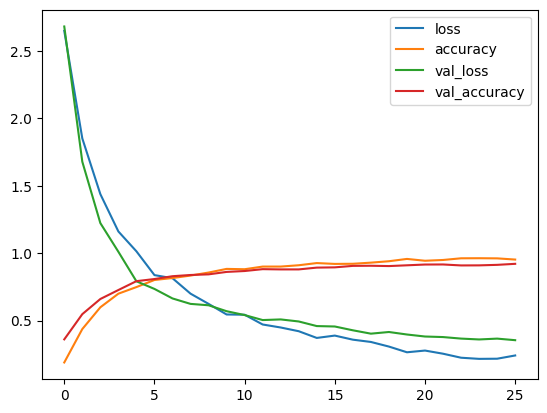

In [36]:
pd.DataFrame(history.history).plot()

## Menyimpan Model

In [37]:
import pathlib

# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi food.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('plants.tflite')
tflite_model_file.write_bytes(tflite_model)

224413140

In [39]:
%cd /content

/content


In [42]:
!zip -r plants_model.zip saved_model/

  adding: saved_model/ (stored 0%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: saved_model/variables/variables.index (deflated 79%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/saved_model.pb (deflated 92%)


In [43]:
from google.colab import files
files.download('plants_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>